# Face Detection with HoG

In [27]:
import numpy as np
import os
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from utils import *

block_size = 2
cell_size = 6
nbins = 9
window_size = np.array([36, 36])

# compute or load features for training
if not (os.path.exists('data/features_pos.npy') and os.path.exists('data/features_neg.npy')):
    features_pos = get_positive_features('data/caltech_faces/Caltech_CropFaces', cell_size, window_size, block_size, nbins)
    num_negative_examples = 10000
    features_neg = get_random_negative_features('data/train_non_face_scenes', cell_size, window_size, block_size, nbins, num_negative_examples)
    np.save('data/features_pos.npy', features_pos)
    np.save('data/features_neg.npy', features_neg)
else:
    features_pos = np.load('data/features_pos.npy')
    features_neg = np.load('data/features_neg.npy')

X = np.vstack((features_pos, features_neg))
Y = np.hstack((np.ones(len(features_pos)), np.zeros(len(features_neg))))

# Train the SVM
clf = LinearSVC(C=1, tol=1e-6, max_iter=10000, fit_intercept=True, loss='hinge')
clf.fit(X, Y)
score = clf.score(X, Y)


## (a) Run detector

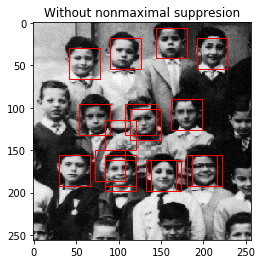

In [31]:
'''
RUN_DETECTOR Given an image, runs the SVM detector and outputs bounding
boxes and scores

Arguments:
    im - the image matrix

    clf - the sklearn SVM object. You will probably use the 
        decision_function() method to determine whether the object is 
        a face or not.
        http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

    window_size - an array which contains the height and width of the sliding
    	window

    cell_size - each cell will be of size (cell_size, cell_size) pixels

    block_size - each block will be of size (block_size, block_size) cells

    nbins - number of histogram bins

Returns:
    bboxes - D x 4 bounding boxes that tell [xmin ymin width height] per bounding
    	box

    scores - the SVM scores associated with each bounding box in bboxes

You can compute the HoG features using the compute_hog_features() method
that you implemented in PS3. We have provided an implementation in utils.py,
but feel free to use your own implementation. You will use the HoG features
in a sliding window based detection approach.

Recall that using a sliding window is to take a certain section (called the 
window) of the image and compute a score for it. This window then "slides"
across the image, shifting by either n pixels up or down (where n is called 
the window's stride). 

Using a sliding window approach (with stride of block_size * cell_size / 2),
compute the SVM score for that window. If it's greater than 1 (the SVM decision
boundary), add it to the bounding box list. At the very end, after implementing 
nonmaximal suppression, you will filter the nonmaximal bounding boxes out.
'''
def run_detector(im, clf, window_size, cell_size, block_size, nbins, thresh=1):
    #print ("Image shape \n", im.shape)
    #print ("Window_size \n", window_size)
    #print ("Cell_size \n" ,cell_size)
    #print ("Block_size \n" ,block_size)
    
    stride = block_size * cell_size / 2
    
    x_windows = (int)(np.floor((im.shape[1]  - window_size[1]) / stride) + 1)
    y_windows = (int)(np.floor((im.shape[0]  - window_size[0]) / stride) + 1)
    
    #print ("Stride\n", stride)
    #print ("X_windows\n", x_windows)
    #print ("Y_windows\n", y_windows)
    
    #print ("X_starts\n", range(0, im.shape[1]  - window_size[1], stride))
    #print ("Y_starts\n", range(0, im.shape[0]  - window_size[0], stride))
    
    sample_img = im[0:window_size[0], :][:, 0:window_size[1]]
    #print ("sample_img\n", sample_img.shape)
    sample_vector = compute_hog_features(sample_img, cell_size, block_size, nbins).reshape(-1)
    #print ("sample_vector\n", sample_vector.shape)
    window_features = np.zeros((y_windows * x_windows, sample_vector.shape[0]))
    #print ("window_features\n", window_features)
    idx = 0
    for y in range(0, im.shape[0]  - window_size[0], stride):
        for x in range(0, im.shape[1]  - window_size[1], stride):
            window_img = im[y:y + window_size[0], :][:, x:x+window_size[1]]
            window_features[idx, :] = compute_hog_features(
                window_img, cell_size, block_size, nbins).reshape(-1)
            idx = idx + 1
    decisions = clf.decision_function(window_features)
    bbox_idxs = np.where(decisions > thresh)[0]
    #print ("Decisions\n", decisions)
    #print ("Bbox_idx\n",bbox_idxs)
    scores = decisions[bbox_idxs]
    #print ("Scores\n", scores)
    bboxes = np.zeros((bbox_idxs.shape[0], 4))
    for (idx, bbox_idx) in enumerate(bbox_idxs):
        y = (int)(np.floor(bbox_idx / x_windows))
        x = bbox_idx - y * x_windows
        bboxes[idx] = [x * stride, y * stride, window_size[1], window_size[0]]
    return (bboxes, scores)

# Part A: Sliding window detector
im = imread('data/people.jpg', 'L').astype(np.uint8)
bboxes, scores = run_detector(im, clf, window_size, cell_size, block_size, nbins)
plot_img_with_bbox(im, bboxes, 'Without nonmaximal suppresion')
plt.show()


## (b) Non maximal supression

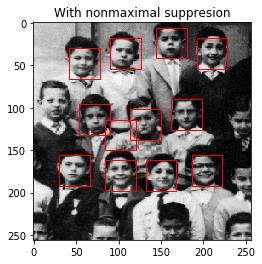

In [29]:
'''
NON_MAX_SUPPRESSION Given a list of bounding boxes, returns a subset that
uses high confidence detections to suppresses other overlapping
detections. Detections can partially overlap, but the
center of one detection can not be within another detection.

Arguments:
    bboxes - ndarray of size (N,4) where N is the number of detections,
        and each row is [x_min, y_min, width, height]
    
    confidences - ndarray of size (N, 1) of the SVM confidence of each bounding
    	box.

    img_size - [height,width] dimensions of the image.

Returns:
    nms_bboxes -  ndarray of size (N, 4) where N is the number of non-overlapping
        detections, and each row is [x_min, y_min, width, height]. Each bounding box
        should not be overlapping significantly with any other bounding box.

In order to get the list of maximal bounding boxes, first sort bboxes by 
confidences. Then go through each of the bboxes in order, adding them to
the list if they do not significantly overlap with any already in the list. 
A significant overlap is if the center of one bbox is in the other bbox.
'''
def non_max_suppression(bboxes, confidences):
    def check_overlap(bbox, nms_bboxes):
        bbox_x_center = bbox[0] + bbox[2] / 2
        bbox_y_center = bbox[1] + bbox[3] / 2
        for nms_bbox in nms_bboxes:
            if (bbox_x_center > nms_bbox[0]
                and bbox_x_center < nms_bbox[0] + nms_bbox[2]
                and bbox_y_center > nms_bbox[1]
                and bbox_y_center < nms_bbox[1] + nms_bbox[3]):
                return True
            nms_bbox_x_center = nms_bbox[0] + nms_bbox[2] / 2
            nms_bbox_y_center = nms_bbox[1] + nms_bbox[3] / 2
            if (nms_bbox_x_center > bbox[0]
                and nms_bbox_x_center < bbox[0] + bbox[2]
                and nms_bbox_y_center > bbox[1]
                and nms_bbox_y_center < bbox[1] + bbox[3]):
                return True

        return False
            
            
        
    sorted_confidences = np.argsort(confidences)
    nms_bboxes = np.zeros_like(bboxes)
    out_idx = 0
    for idx in sorted_confidences:
        if check_overlap(bboxes[idx], nms_bboxes[0:out_idx, :]) is False:
            nms_bboxes[out_idx] = bboxes[idx]
            out_idx = out_idx + 1
    
    return nms_bboxes[0:out_idx, :]
    
# Part B: Nonmaximal suppression
bboxes = non_max_suppression(bboxes, scores)
plot_img_with_bbox(im, bboxes, 'With nonmaximal suppresion')
plt.show()


# Image segementation

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.misc import imread
from scipy.spatial.distance import cdist


np.random.seed()

def draw_clusters_on_image(im, pixel_clusters):
    num_clusters = int(pixel_clusters.max()) + 1
    average_color = np.zeros((num_clusters, 3))
    cluster_count = np.zeros(num_clusters)

    for i in xrange(im.shape[0]):
        for j in xrange(im.shape[1]):
            c = pixel_clusters[i,j]
            cluster_count[c] += 1
            average_color[c, :] += im[i, j, :]

    for c in xrange(num_clusters):
        average_color[c,:] /= float(cluster_count[c])
        
    out_im = np.zeros_like(im)
    for i in xrange(im.shape[0]):
        for j in xrange(im.shape[1]):
            c = pixel_clusters[i,j]
            out_im[i,j,:] = average_color[c,:]

    return out_im


## (a) K-means with num_clusters = 5

In [38]:
'''
KMEANS_SEGMENTATION: Image segmentation using kmeans 
Arguments:
    im - the image being segmented, given as a (H, W, 3) ndarray

    features - ndarray of size (#pixels, M) that are the feature vectors 
        associated with each pixel. The #pixels are arranged in such a way
        that calling reshape((H,W)) will correspond to the image im.

    num_clusters - The parameter "K" in K-means that tells the number of 
        clusters we will be using.

Returns:
    pixel_clusters - H by W matrix where each index tells what cluster the
        pixel belongs to. The clusters must range from 0 to N-1, where N is
        the total number of clusters.

The K-means algorithm can be done in the following steps:
(1) Randomly choose the initial centroids from the features
(2) Repeat until convergence:
    - Assign each feature vector to its nearest centroid
    - Compute the new centroids as the average of all features assigned to it
    - Convergence happens when the centroids do not change
'''
def kmeans_segmentation(im, features, num_clusters):
    #print ("num_clusters\n", num_clusters)
    idxs = np.random.choice(features.shape[0], num_clusters)
    #print ("Idxs\n", idxs)
    centroids = features[idxs, :]
    #print ("centroids\n", centroids)
    clusters_assigned = np.zeros(features.shape[0])
    while True:
        for i in range(0, features.shape[0]):
            distances = np.linalg.norm(centroids - features[i], axis = 1)
            min_idx = np.argmin(distances)
            clusters_assigned[i] = min_idx
        new_centroids = np.zeros_like(centroids)
        for j in range(0, num_clusters):
            c_idx = np.where(clusters_assigned == j)[0]
            new_centroids[j] = np.mean(features[c_idx, :])
        centroids_change = centroids - new_centroids
        if np.linalg.norm(centroids_change) == 0:
            break
        centroids = new_centroids
    #print ("clusters_assigned\n", clusters_assigned.reshape((im.shape[0], im.shape[1])).astype(int))
    return clusters_assigned.reshape((im.shape[0], im.shape[1])).astype(int)

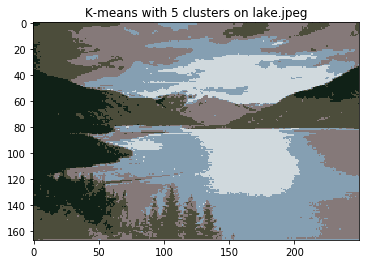

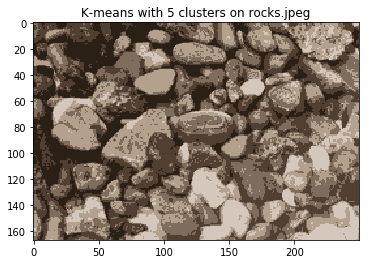

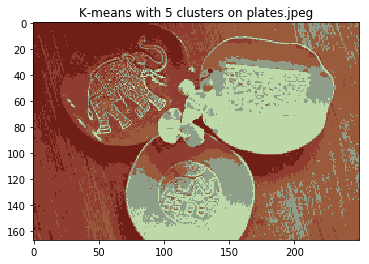

In [39]:
# Change these parameters to see the effects of K-means and Meanshift
num_clusters = [5]
bandwidths = [0.3]


for filename in ['lake', 'rocks', 'plates']:
    img = imread('data/%s.jpeg' % filename) 

    # Create the feature vector for the images
    features = np.zeros((img.shape[0] * img.shape[1], 5))
    for row in xrange(img.shape[0]):
        for col in xrange(img.shape[1]):
            features[row*img.shape[1] + col, :] = np.array([row, col, 
                img[row, col, 0], img[row, col, 1], img[row, col, 2]])
    features_normalized = features / features.max(axis = 0)

    # Part I: Segmentation using K-Means
    for nc in num_clusters:
        clustered_pixels = kmeans_segmentation(img, features_normalized, nc)
        cluster_im = draw_clusters_on_image(img, clustered_pixels)
        plt.imshow(cluster_im)
        plt.title('K-means with %d clusters on %s.jpeg' % (int(nc), filename))
        plt.show()


## (b) K-means with varying num_clusters.

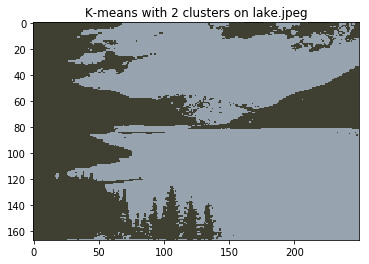

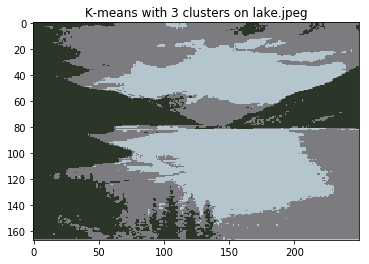

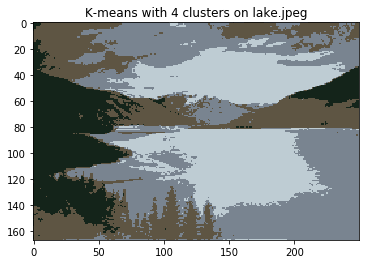

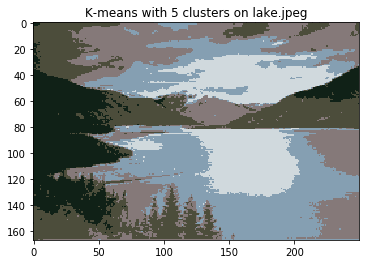

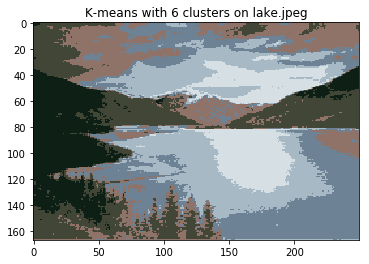

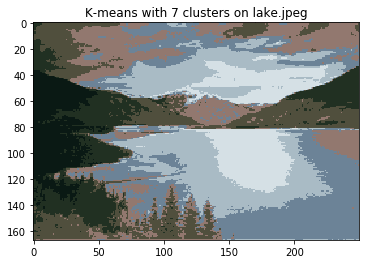

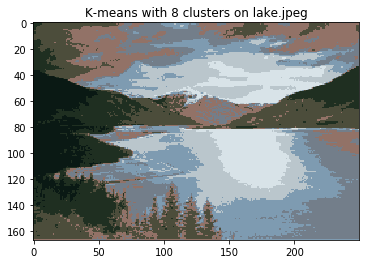

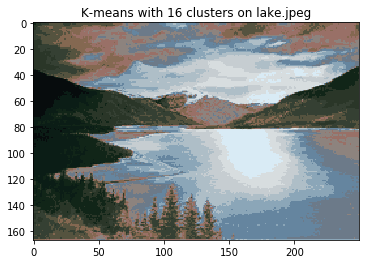

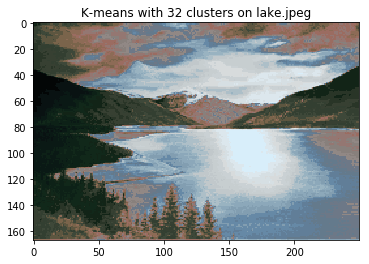

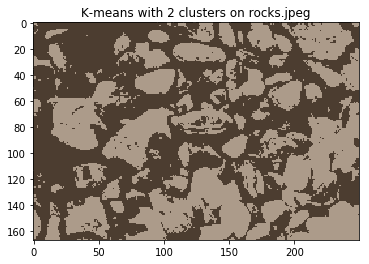

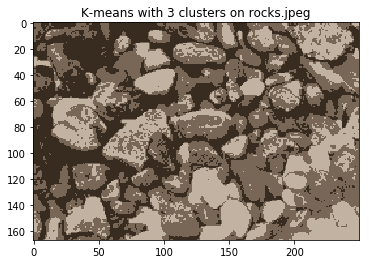

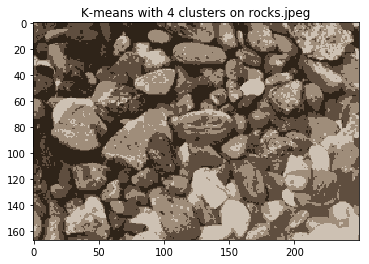

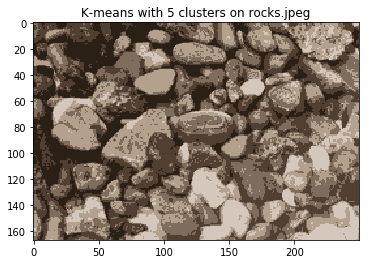

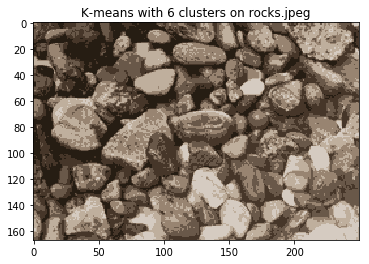

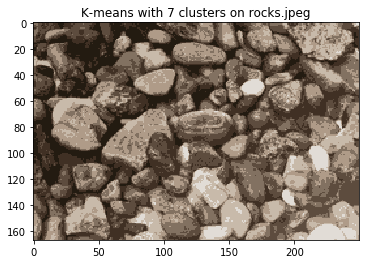

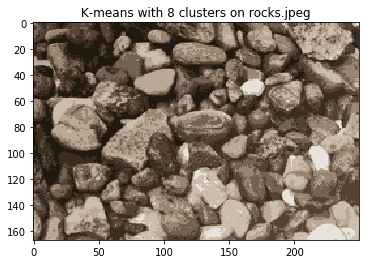

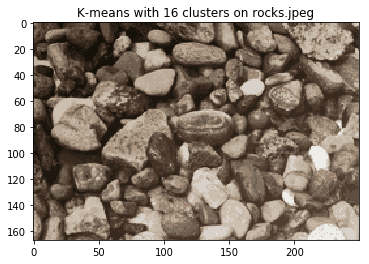

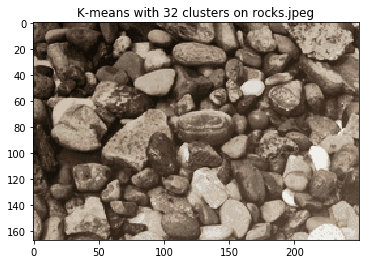

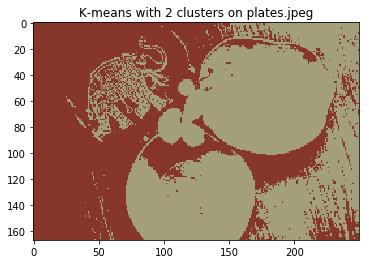

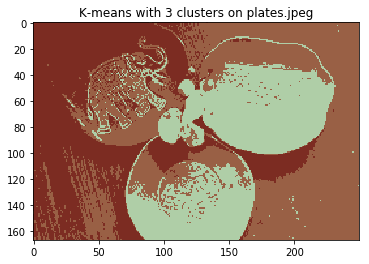

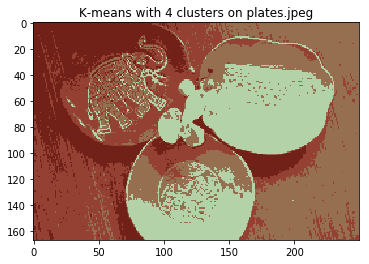

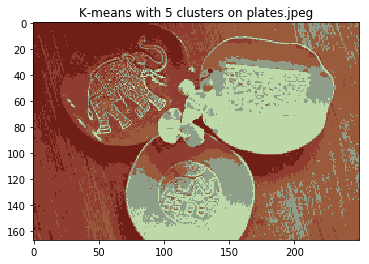

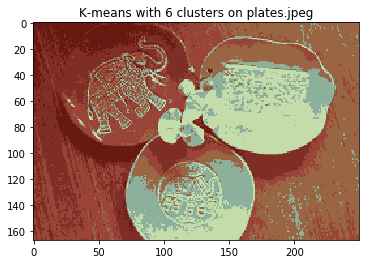

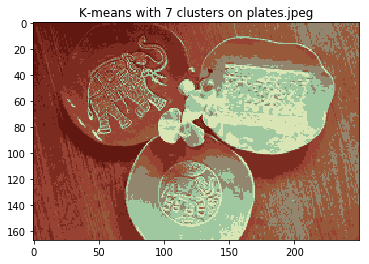

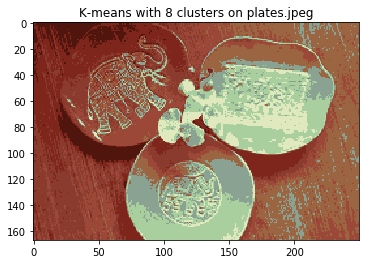

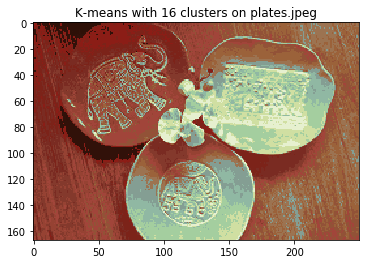

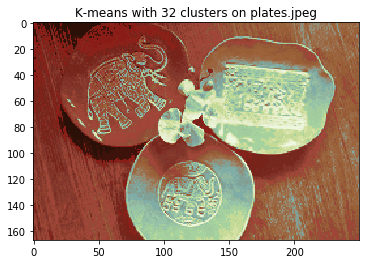

In [41]:
# Change these parameters to see the effects of K-means and Meanshift
num_clusters = [2, 3, 4, 5, 6, 7, 8, 16, 32]
bandwidths = [0.3]


for filename in ['lake', 'rocks', 'plates']:
    img = imread('data/%s.jpeg' % filename) 

    # Create the feature vector for the images
    features = np.zeros((img.shape[0] * img.shape[1], 5))
    for row in xrange(img.shape[0]):
        for col in xrange(img.shape[1]):
            features[row*img.shape[1] + col, :] = np.array([row, col, 
                img[row, col, 0], img[row, col, 1], img[row, col, 2]])
    features_normalized = features / features.max(axis = 0)

    # Part I: Segmentation using K-Means
    for nc in num_clusters:
        clustered_pixels = kmeans_segmentation(img, features_normalized, nc)
        cluster_im = draw_clusters_on_image(img, clustered_pixels)
        plt.imshow(cluster_im)
        plt.title('K-means with %d clusters on %s.jpeg' % (int(nc), filename))
        plt.show()


## (c) Meanshift segmentation

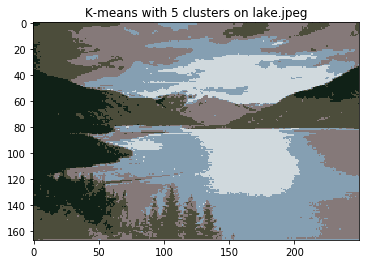

Exception: Not Implemented Error

In [35]:
'''
MEANSHIFT_SEGMENTATION: Image segmentation using meanshift
Arguments:
    im - the image being segmented, given as a (H, W, 3) ndarray

    features - ndarray of size (#pixels, M) that are the feature vectors 
        associated with each pixel. The #pixels are arranged in such a way
        that calling reshape((H,W)) will correspond to the image im.

    bandwidth - A parameter that determines the radius of what particpates
       in the mean computation

Returns:
    pixel_clusters - H by W matrix where each index tells what cluster the
        pixel belongs to. The clusters must range from 0 to N-1, where N is
        the total number of clusters.

The meanshift algorithm can be done in the following steps:
(1) Keep track of an array whether we have seen each pixel or not.
Initialize it such that we haven't seen any.
(2) While there are still pixels we haven't seen do the following:
    - Pick a random pixel we haven't seen
    - Until convergence (mean is within 1 of the bandwidth of the old
        mean), mean shift. The output of this step will be a mean vector.
        For each iteration of the meanshift, if another pixel is within the
        bandwidth circle (in feature space), then that pixel should also be
        marked as seen
    - If the output mean vector from the mean shift step is
        sufficiently close (within half a bandwidth) to another cluster
        center, say it's part of that cluster
    - If it's not sufficiently close to any other cluster center, make
        a new cluster
(3) After finding all clusters, assign every pixel to the nearest cluster
in feature space.

To perform mean shift:
    - Once a random pixel has been selected, pretend it is the current mean
        vector.
    - Find the feature vectors of the other pixels that are within the
        bandwidth distance from the mean feature vector according to EUCLIDEAN
        distance (in feature space).
    - Compute the mean feature vector among all feature vectors within the
        bandwidth.
    - Repeat until convergence, using the newly computed mean feature vector
        as the current mean feature vector.
'''
def meanshift_segmentation(im, features, bandwidth):
    

# Change these parameters to see the effects of K-means and Meanshift
num_clusters = [5]
bandwidths = [0.3]


for filename in ['lake', 'rocks', 'plates']:
    img = imread('data/%s.jpeg' % filename) 

    # Create the feature vector for the images
    features = np.zeros((img.shape[0] * img.shape[1], 5))
    for row in xrange(img.shape[0]):
        for col in xrange(img.shape[1]):
            features[row*img.shape[1] + col, :] = np.array([row, col, 
                img[row, col, 0], img[row, col, 1], img[row, col, 2]])
    features_normalized = features / features.max(axis = 0)

    # Part II: Segmentation using Meanshift
    for bandwidth in bandwidths:
        clustered_pixels = meanshift_segmentation(img, features_normalized, bandwidth)
        cluster_im = draw_clusters_on_image(img, clustered_pixels)
        plt.imshow(cluster_im)
        plt.title('Meanshift with bandwidth %.2f on %s.jpeg' % (bandwidth, filename))
        plt.show()